In [9]:

with h5py.File(path_to_h5, 'r') as hf:
    print(hf["train"].keys())
    print(hf["train/data"].shape)
    print(hf["train/ev_chars"].shape)
    

<KeysViewHDF5 ['data', 'ev_chars', 'ev_ids', 'labels_full', 'labels_num_mu', 'labels_one_mu', 'labels_particle', 'labels_signal_noise', 'labels_track_type', 'mask']>
(1694740, 97, 5)
(1694740, 4)


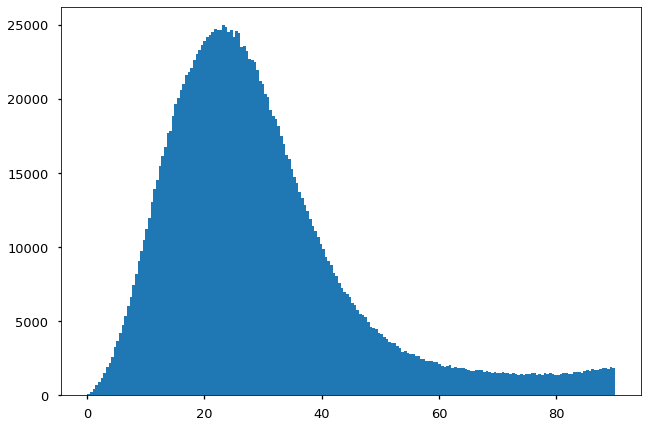

In [20]:
# полярный
with h5py.File(path_to_h5, 'r') as hf:
    plt.hist(hf["train/ev_chars"][:,0],bins= 200)
    

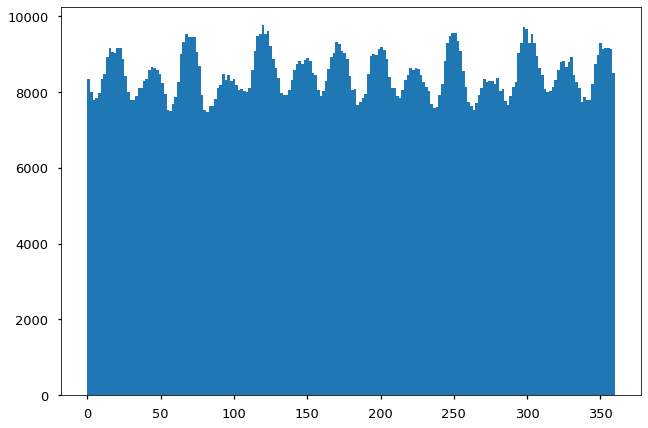

In [19]:
# азимутальный,видно 14 пиков
with h5py.File(path_to_h5, 'r') as hf:
    plt.hist(hf["train/ev_chars"][:,1],bins=200)
    

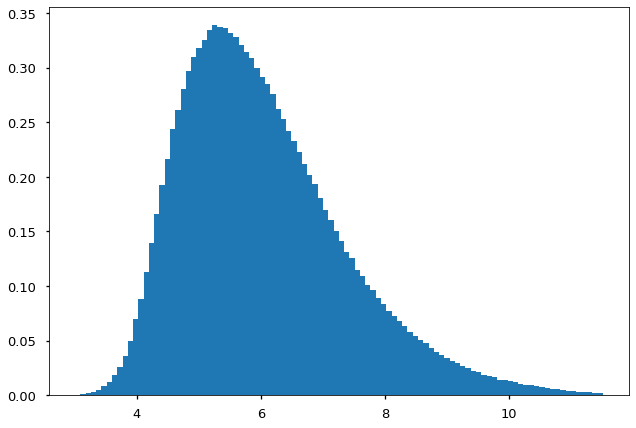

In [18]:
# энергия сразу по логарифму
with h5py.File(path_to_h5, 'r') as hf:
    plt.hist(np.log(hf["train/ev_chars"][:,2]),bins = 100, density =True)
    

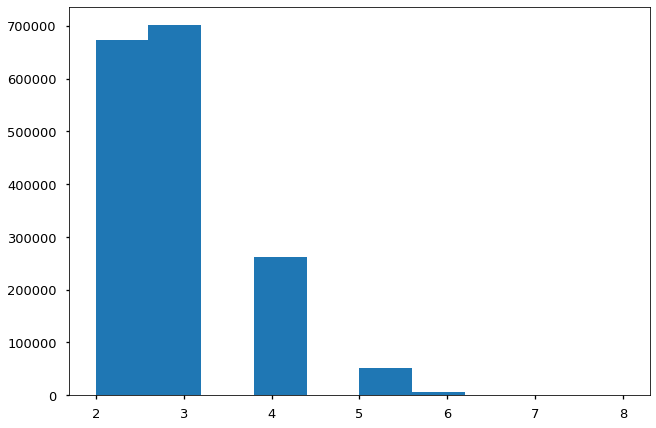

In [17]:
# срабатывания по количеству струн
with h5py.File(path_to_h5, 'r') as hf:
    plt.hist(hf["train/ev_chars"][:,3])  

In [40]:
for i, j in zip(a[0],a[1]):
    print(j,i)

8.0 1008227.0
9.05 236389.0
10.1 149449.0
11.15 96270.0
12.2 64052.0
13.25 43039.0
14.3 29083.0
15.35 20341.0
16.4 13960.0
17.45 9909.0
18.5 6911.0
19.55 4942.0
20.6 3316.0
21.65 2418.0
22.7 1726.0
23.75 1194.0
24.8 851.0
25.85 649.0
26.9 448.0
27.95 334.0
29.0 491.0
30.05 152.0
31.1 146.0
32.15 104.0
33.2 63.0
34.25 69.0
35.3 43.0
36.35 42.0
37.4 31.0
38.45 15.0
39.5 12.0
40.55 10.0
41.6 9.0
42.65 6.0
43.7 8.0
44.75 5.0
45.8 2.0
46.85 3.0
47.9 1.0
48.95 1.0
50.0 4.0
51.05 5.0
52.1 4.0
53.15 0.0
54.2 0.0
55.25 1.0
56.3 0.0
57.35 1.0
58.4 0.0
59.45 1.0
60.5 0.0
61.55 1.0
62.6 1.0
63.65 0.0
64.7 0.0
65.75 0.0
66.8 0.0
67.85 0.0
68.9 0.0
69.95 1.0


(1694740, 97)


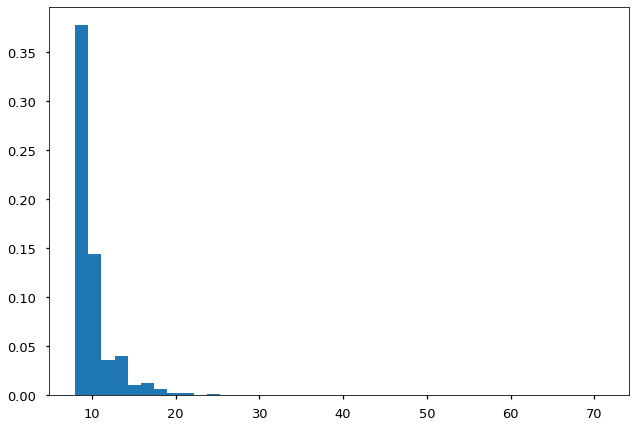

In [24]:
# по количеству срабатываний OM
with h5py.File(path_to_h5, 'r') as hf:
    #plt.hist(hf["train/ev_chars"][:,0])
    print(hf["train/mask"].shape)
    plt.hist(np.sum(hf["train/mask"],axis=1),bins=40,density = True)

In [35]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
#from sklearn.metrics import r2_score
device = torch.device('cuda:1') if torch.cuda.is_available else torch.device('cpu')
print(device)
%matplotlib inline
np.random.seed(1)
plt.style.use("seaborn-talk") #"classic" "seaborn-talk" "seaborn"
path_to_h5 =  "/home/leonov/Baikal/Cut_8_nu/APRIL/Ordered/Data/mc_baikal_norm_cut-8_ordered_equal_big.h5"

# можно отделить хвост и отдельно прогнать его по другой сетке
def make_trainset_noxyz(i, di = 1, tr_set_len = 128,Batch_size = 64):
    with h5py.File(path_to_h5, 'r') as hf:
            Data = hf['train/data/'][i*int(tr_set_len) : (i+di)*int(tr_set_len),:32]
            Polar=hf["/train/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),0]*(np.pi)/180
            Azimut=hf["/train/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),1]*(np.pi)/180
            x=np.expand_dims(np.sin(Polar)*np.cos(Azimut),axis=1)
            y=np.expand_dims(np.sin(Polar)*np.sin(Azimut),axis=1)
            z=np.expand_dims(np.cos(Polar),axis=1)
            target=torch.FloatTensor(np.concatenate((x,y,z) ,axis=1))
            Data = torch.FloatTensor(Data.swapaxes(1, -1)) # надо,т.к. второй индекс должен быть количеством   последовательностей
            trainDataset = torch.utils.data.TensorDataset(Data, target)
            trainLoader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=Batch_size) #,sampler = sampler    
    return  trainLoader
def make_valset_noxyz(i=0, di = 1, tr_set_len = 1000, Batch_size = 64):
    with h5py.File(path_to_h5, 'r') as hf:
            Data = hf['val/data/'][i*int(tr_set_len) : (i+di)*int(tr_set_len),:32] # ибо очень редко как то задействовано более чем 32 OM
            Data = torch.FloatTensor(Data.swapaxes(1, -1)) 
            Polar=hf["/val/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),0]*(np.pi)/180
            Azimut=hf["/val/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),1]*(np.pi)/180
            #
            x=np.expand_dims(np.sin(Polar)*np.cos(Azimut),axis=1)
            y=np.expand_dims(np.sin(Polar)*np.sin(Azimut),axis=1)
            z=np.expand_dims(np.cos(Polar),axis=1)
            target=torch.FloatTensor(np.concatenate((x,y,z) ,axis=1))
            testDataset = torch.utils.data.TensorDataset(Data, target)
            testLoader = torch.utils.data.DataLoader(dataset = testDataset, batch_size=Batch_size)
    return testLoader
# вектора в углы
def v_to_angles( Predicted, Real,
                p_hist, az_hist, 
                p_error_hist,p_error_angle_cut_hist,
                min_angle = 10., max_angle = 60.): 
    #Predict = torch.nn.functional.normalize(model(torch.Tensor(Predict).to(device).float() )).cpu().detach().numpy()
    v_pred = torch.nn.functional.normalize(Predicted.detach()) # нормализую
    #полярный получаю просто и в градусах
    polar_real = torch.acos(Real[:,-1])/(np.pi)*180 
    polar_predicted = torch.acos(v_pred[:,-1])/(np.pi)*180 
    # azimut
    azimut =torch.acos( v_pred[:,0]/((v_pred[:,0])**2+(v_pred[:,1])**2+1e-8)**0.5 ) # добавляю  в знаменатель добавку чтоб наны не получить
    azimut = azimut+(torch.sign(v_pred[:,1])**2)*(1-torch.sign(v_pred[:,1]))*(np.pi-azimut) # torch.sign(v[:,1])**2 на случай нулевых углов,которых нет
    azimut = azimut/(np.pi)*180 # привожу к градусам
    azimut=azimut.short()
    #polar = polar.short()
    for pol_pred, pol_real, az in zip(polar_predicted, polar_real, azimut):
        p_error_hist[round(abs((pol_pred-pol_real).item()),1)] += 1
        # for certain angles !!!!!!!!!!!!!!!!!!!!!!!
        if (pol_real.item() >= min_angle) and (pol_real.item() <= max_angle): 
            p_error_angle_cut_hist[round(abs((pol_pred-pol_real).item()),1)] += 1        
        p_hist[pol_pred.short().item()] += 1
        az_hist[az.item()] += 1
    
def resolution_calculation(Predicted,Real,
                           hist,hist_angle_cut,
                           min_angle = 10., max_angle = 60.
                          ):
    res = torch.acos(torch.nn.functional.cosine_similarity(Predicted,Real,dim = 1))/np.pi*180
    res = torch.nn.functional.cosine_similarity(Predicted,Real,dim = 1)
    res = torch.acos(res)/np.pi*180
    polar_real = torch.acos(Real[:,-1])/(np.pi)*180  # для сравнения
    for i,res_value in enumerate(res):
        try:
            hist[round(res_value.item(),1)] += 1
            if (polar_real[i].item() >= min_angle) and (polar_real[i].item() <= max_angle) :
                hist_angle_cut[round(res_value.item(),1)] += 1
        except KeyError:
            hist[0.0] += 1
            print(res_value.item(),"torch is bad at acos calculation")
def loss_plot(list_test, list_train , path , save = True):
    plt.figure(figsize=(9,6))
    plt.plot(np.arange(len(list_test)), list_test, label='val', linewidth=2)
    plt.plot(np.arange(len(list_train)), list_train, label='train', linewidth=2)
    plt.title('Loss_plot')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    if save == True:
        plt.savefig(path)
    plt.show()
def res_plot(train_dict,val_dict, path = None,save = True, res_or_polar = "Resolution " ,size= 13):
    plt.figure(figsize=(13,5))
    colours=["red","red"]
    names = ["train" , "val"]
    for i, d in enumerate([train_dict,val_dict]):
        plt.subplot(1,2,i+1)
        s = sum(d.values())
        prep_inter_s ,inter_s = 0, 0
        res_50, res_68 =0,0
        for key in list(d.keys()):
            if inter_s/s >= 0.68:
                alpha = (inter_s-0.68*s)/(inter_s-prep_inter_s) # alpha*inter_s+(1-alpha)*prep_inter_s == 0.68*s
                res_68 =round(key + 0.1*alpha,2)  #alpha*(key-0.1)+(1-alpha)*(key)
                break
            if inter_s/s >= 0.5 and res_50 == 0:
                alpha = (inter_s-0.5*s)/(inter_s-prep_inter_s)
                res_50 =round(key + 0.1*alpha,2)
            prep_inter_s = inter_s 
            inter_s  += d[key]  
        a=plt.step(list(d.keys())[:300], list(d.values())[:300], color=colours[i],alpha = 0.6)
        plt.bar(res_50, max(d.values()), width=0.5,label=names[i] + "50%" + res_or_polar +"= "+str(res_50),
                color="yellow" , alpha =0.7 )
        plt.bar(res_68, max(d.values()), width=0.5,label=names[i] + "68%" + res_or_polar +" = "+str(res_68) ,
                color="orange",alpha = 0.7)
        plt.legend(); plt.suptitle(res_or_polar,fontsize =size+3)
        plt.xlabel(res_or_polar + "in_grad",fontsize= size); plt.title(res_or_polar + names[i],fontsize= size)
    if save == True:
        plt.savefig(path) 
    plt.show()

def angle_hist(hist_polar,hist_azimut,path, save =True,size= 13,name = "train"):
    with h5py.File(path_to_h5, 'r') as hf:
        plt.figure(figsize= (13,10))
        sum_value = sum(hist_polar.values())
        Polar=hf["/"+name+"/ev_chars"][ : ,0] 
        Azimut=hf["/"+name+"/ev_chars"][ : ,1]
        plt.subplot(2,1,1)
        plt.hist(Polar,bins=180,label=name+" Polar",density=True,histtype="step",color="blue")
        plt.bar(list(hist_polar.keys())[:100], np.array(list(hist_polar.values())[:100])/sum_value, 
                color="red",label=name+" Polar_Predicted")
        plt.legend()
        plt.xlabel("Polar_Angle",fontsize= size); plt.title(name+"_Polar",fontsize= size)
        plt.subplot(2,1,2) 
        plt.hist(Azimut,bins=360,label=name+" Azimut",density=True,histtype="step",color="blue")
        plt.bar(list(hist_azimut.keys()), np.array(list(hist_azimut.values()))/sum_value,
                    align = 'center', color="red",label=name+" Azimut_Predicted")
        plt.legend()
        plt.xlabel("Azimut_Angle",fontsize= size) ;plt.title(name+"_Azimut",fontsize= size)
        if save == True:
            plt.savefig(path) 
        plt.show()


cuda:1


In [36]:
#a = torch.ones((512,32,5)).swapaxes(1, -1)
net = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 0 ),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    torch.nn.Conv1d(5, 10,  kernel_size=3, stride = 2 ,padding = 0),
    torch.nn.BatchNorm1d(10),
    torch.nn.PReLU(),
    torch.nn.Conv1d(10,20,  kernel_size=3, stride=2,padding=0 ),
    torch.nn.BatchNorm1d(20),
    torch.nn.PReLU(),
    torch.nn.Conv1d(20,40,  kernel_size=3, stride=2,padding=0 ),
    torch.nn.BatchNorm1d(40),
    torch.nn.PReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(80,40),
    torch.nn.BatchNorm1d(40),
    torch.nn.PReLU(),
    torch.nn.Linear(40,20),
    torch.nn.BatchNorm1d(20),
    torch.nn.PReLU(),
    torch.nn.Linear(20 ,3)
) 

#net(a).shape
sum(p.numel() for p in net.parameters()   )

7699

In [37]:
def fitting(model, scheduler_Exp, scheduler_MultiStep , optimizer,
        min_angle = 10. ,max_angle = 60.0,
        epochs_num = 25, batch_size = 64,
        criterion=torch.nn.L1Loss(),
        save_weights = True, save_plot = True, save_resolution = True,  save_angles = True, save_polar_error = True,   
        suffix = "Nu_MAE_Res_1D",
        path_begin = "/home/leonov/Baikal/Cut_8_nu/APRIL/Ordered"
           ):
    tr_set_len = 512*100
    seq = [j for j in range(int( 1881011/tr_set_len))]
    print('Num of sub-epochs in Epoch = ', len(seq), '\n')
    len_seq = len(seq)
    #optimizer = torch.optim.Adam(model.parameters(),lr=learn_rate)
    #scheduler_Exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
    #scheduler_MultiStep = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10,20,30,40,42], gamma=0.5) 
    loss_train = []
    loss_test = []
    
    # здесь будут polar error всех событий
    hist_train_polar_error = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    hist_val_polar_error = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    
    # здесь будут polar error углов от min_angle до max_angle
    hist_train_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    hist_val_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    
    # здесь будут гистограммы  разрешения всех событий
    hist_train_res = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    hist_val_res = {round(k,1):0 for k in np.arange(0.0, 180, 0.1)}
    
    # здесь будут гистограммы  разрешения от min_angle до max_angle
    hist_train_res_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    hist_val_res_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)}
    
    # гистограммы  предсказанных углов для сравнения с реальным распределением     
    hist_train_polar = {k:0 for k in np.arange(0, 181, 1)}
    hist_train_azimut = {k:0 for k in np.arange(0, 361, 1)}
    hist_val_polar = {k:0 for k in np.arange(0, 181, 1)} 
    hist_val_azimut = {k:0 for k in np.arange(0, 361, 1)} 
    
    num = 0
    for n in range(1, epochs_num+1):
        #training
        print('\n','Indeed Epoch = ', n)
        for i in seq:
            train_Loader = make_trainset_noxyz(i,1,tr_set_len,Batch_size = batch_size)
            for x_batch,y_batch in train_Loader:
                optimizer.zero_grad()
                outp = model(x_batch.to(device).float())
                loss =   criterion(outp,y_batch.to(device).float())
                loss.backward()
                optimizer.step()
                # полученный вектор направления превращаю в углы и добавляю в гистограммы
                if n == epochs_num:
                    v_to_angles(Predicted = outp, Real = y_batch.to(device),
                                p_error_hist = hist_train_polar_error,
                                p_error_angle_cut_hist = hist_train_polar_error_angle_cut,
                                p_hist = hist_train_polar, az_hist = hist_train_azimut,
                                min_angle = min_angle, max_angle = max_angle)
                    resolution_calculation(outp,y_batch.to(device),
                                           min_angle = min_angle ,max_angle = max_angle,
                                           hist = hist_train_res,
                                           hist_angle_cut = hist_train_res_angle_cut  )
            if (num%(len_seq//3) == 0):
                rand_ind=np.random.randint(0,15)
                print('Sub-epoch number = ', num)
                loss_train.append(loss.item())
                model.eval()
                testLoader = make_valset_noxyz(rand_ind,1,500, Batch_size = batch_size)
                test_loss=0
                count=0
                for x_test_batch,y_test_batch in testLoader:
                    outp = model(x_test_batch.to(device).float())
                    test_loss +=  criterion(outp,y_test_batch.to(device).float()).item()
                    count+=1
                test_loss /=count
                loss_test.append(test_loss)
                model.train()
                print("train_loss = ",loss.item(),"  val_loss = ",test_loss)
            num+=1
        scheduler_Exp.step()
        scheduler_MultiStep.step()
    # гистограммы для val датасета     
    model.eval()
    FinalLoader = make_valset_noxyz(0,-1,1, Batch_size = batch_size) # делаю  loader из всего датасета
    for x_test_batch,y_test_batch in FinalLoader:
        outp = model(x_test_batch.to(device).float())
        v_to_angles(Predicted = outp, Real = y_test_batch.to(device),
                    p_error_hist = hist_val_polar_error,
                    p_error_angle_cut_hist = hist_val_polar_error_angle_cut,
                    p_hist = hist_val_polar, az_hist = hist_val_azimut,
                    min_angle = min_angle, max_angle = max_angle)
        resolution_calculation(outp, y_test_batch.to(device),
                               min_angle = min_angle ,max_angle = max_angle,
                               hist = hist_val_res,
                               hist_angle_cut = hist_val_res_angle_cut )
        
    if save_weights == True:
        torch.save(model.state_dict(), path_begin + "/states/" + suffix + "model")
        torch.save(optimizer.state_dict(), path_begin + "/states/" + suffix + "opt")
        
    # график лосса
    loss_plot(loss_test, loss_train , path_begin + "/Images/Loss/" + suffix + "LOSS.png", 
              save_plot )
    
    #  гистограмма ошибок  полярного угла
    res_plot(hist_train_polar_error, hist_val_polar_error, 
             path = path_begin + "/Images/Polar_Error/" + suffix+ "Polar_Error.png",
             save = save_polar_error, res_or_polar = "Polar_Error ")
 
    #  гистограмма ошибок  полярного угла для определенных углов
    res_plot(hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut, 
             path = path_begin + "/Images/Polar_Error_Angle_Cut/" + suffix+ "Polar_Error_Angle_Cut.png",
             save = save_polar_error, res_or_polar = "Polar_Error_Angle_Cut ")  
    
    # гистограммы разрешения
    res_plot(hist_train_res,hist_val_res,
             path = path_begin + "/Images/Resolution/" + suffix + "RESOLUTIONS.png",
             save = save_resolution,res_or_polar = "Resolution ")
    
    # гистограммы разрешения для определенных углов
    res_plot(hist_train_res_angle_cut,hist_val_res_angle_cut,
             path = path_begin + "/Images/Resolution_Angle_Cut/" + suffix + "Resolution_Angle_Cut.png",
             save = save_resolution,res_or_polar = "Resolution_Angle_Cut ")
    
    #гистограммы углов
    angle_hist(hist_train_polar,hist_train_azimut, name='train',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_train.png", 
               save = save_angles)
    angle_hist(hist_val_polar,hist_val_azimut, name='val',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_val.png", 
               save = save_angles)
    
    loss_lists = [loss_train , loss_test]
    polar_hists = [hist_train_polar , hist_val_polar]
    azimut_hists = [hist_train_azimut, hist_val_azimut]
    res_hists = [hist_train_res, hist_val_res,
                 hist_train_res_angle_cut, hist_val_res_angle_cut]
    polar_error = [hist_train_polar_error, hist_val_polar_error,
                   hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut
                  ]
    model.train()
    return  loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error




# Первая проба пера,надо бы сделать lr ,больше 0.02..


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.06482645869255066   val_loss =  0.06307248864322901
Sub-epoch number =  12
train_loss =  0.06021283194422722   val_loss =  0.05674153799191117
Sub-epoch number =  24
train_loss =  0.06604846566915512   val_loss =  0.053544556722044945

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.06181794032454491   val_loss =  0.052759187296032906
Sub-epoch number =  48
train_loss =  0.061647720634937286   val_loss =  0.05038874503225088
Sub-epoch number =  60
train_loss =  0.06224662810564041   val_loss =  0.05358885694295168

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.05874546617269516   val_loss =  0.05399918556213379
Sub-epoch number =  84
train_loss =  0.060821738094091415   val_loss =  0.05970986373722553
Sub-epoch number =  96
train_loss =  0.059830110520124435   val_loss =  0.05567176919430494

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.056325800716876984   val_loss =  0.05370624549686909
Sub-

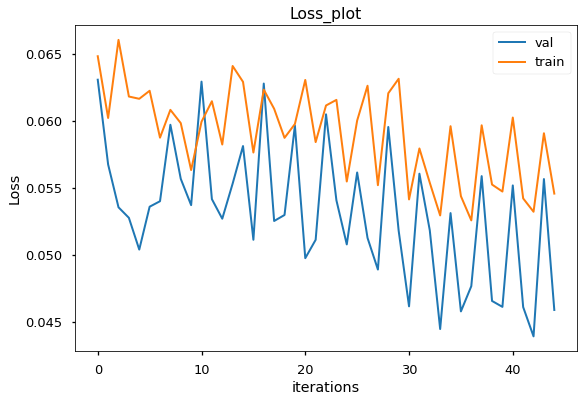

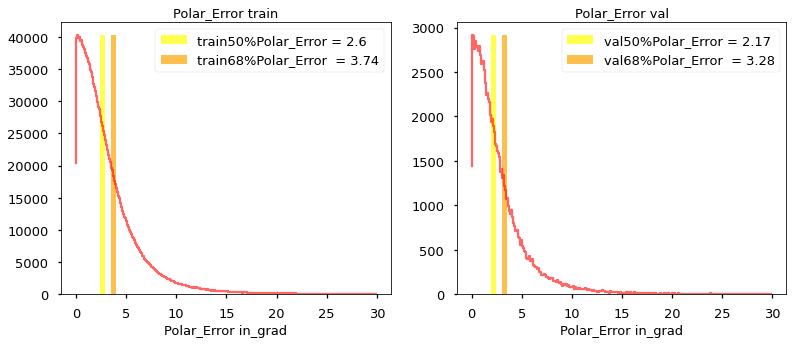

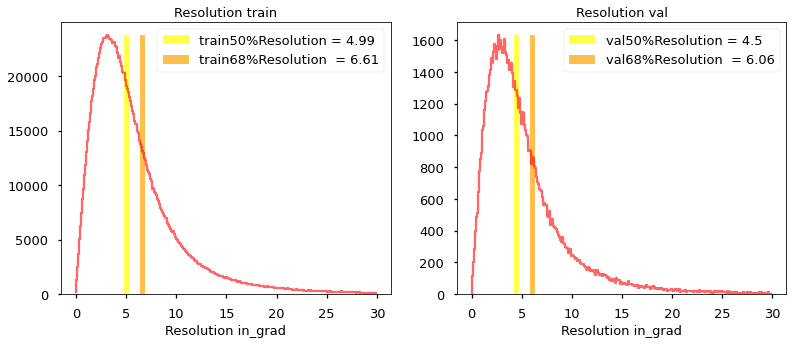

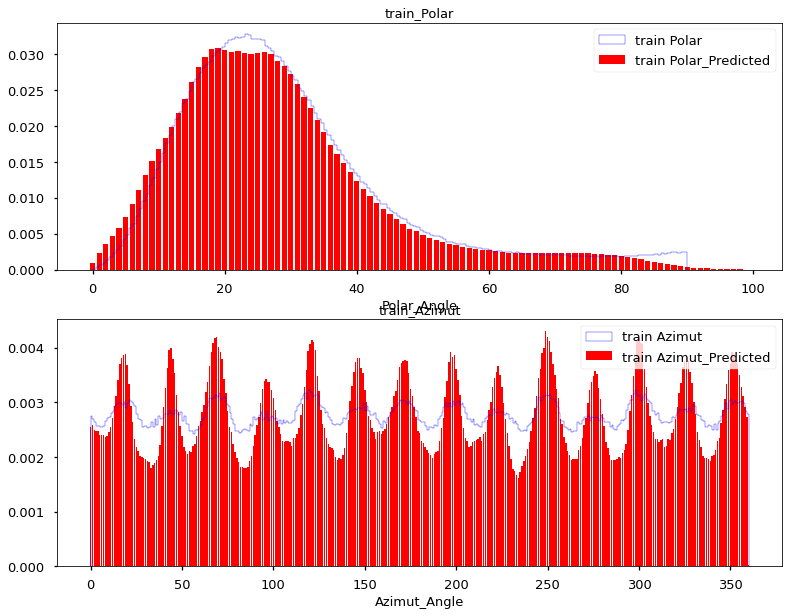

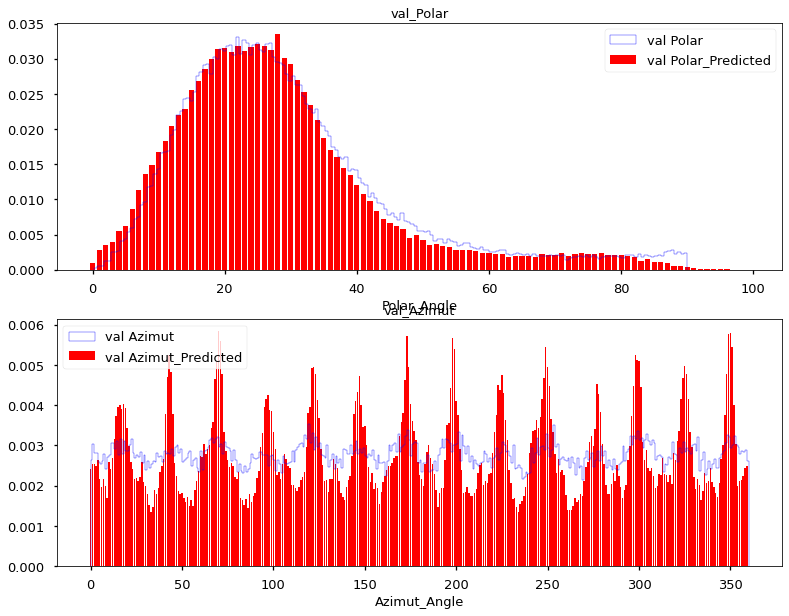

In [16]:
'''
model = net.to(device)
learn_rate =2e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[10,20,30,40,45], gamma=0.7) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Usual_1D",
                                                                       epochs_num=15, batch_size =64)
'''                                                                    

Num of sub-epochs in Epoch =  36 


 Indeed Epoch =  1
Sub-epoch number =  0
train_loss =  0.05042147636413574   val_loss =  0.04807861056178808
Sub-epoch number =  12
train_loss =  0.052971284836530685   val_loss =  0.04824820952489972
Sub-epoch number =  24
train_loss =  0.05369981378316879   val_loss =  0.0476620988920331

 Indeed Epoch =  2
Sub-epoch number =  36
train_loss =  0.05039113759994507   val_loss =  0.0435998123139143
Sub-epoch number =  48
train_loss =  0.05155244097113609   val_loss =  0.05283775506541133
Sub-epoch number =  60
train_loss =  0.05322698876261711   val_loss =  0.04671531217172742

 Indeed Epoch =  3
Sub-epoch number =  72
train_loss =  0.04943672940135002   val_loss =  0.04725841246545315
Sub-epoch number =  84
train_loss =  0.051878225058317184   val_loss =  0.04429572820663452
Sub-epoch number =  96
train_loss =  0.05396483093500137   val_loss =  0.04354463703930378

 Indeed Epoch =  4
Sub-epoch number =  108
train_loss =  0.049523673951625824   val_lo

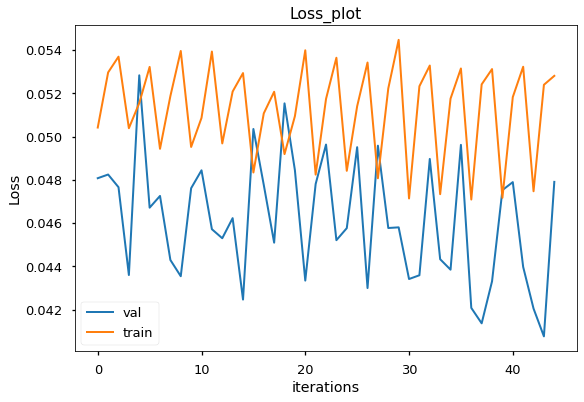

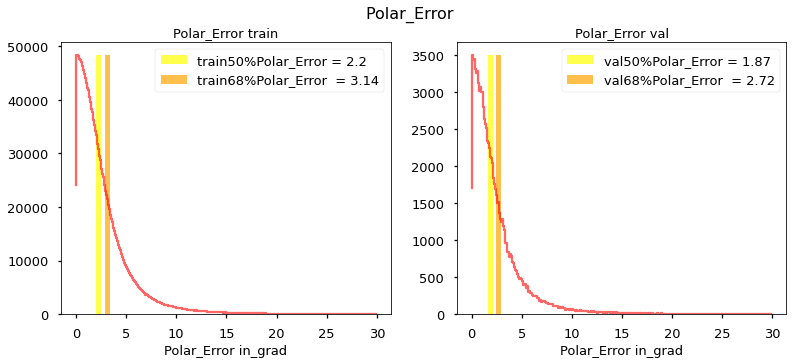

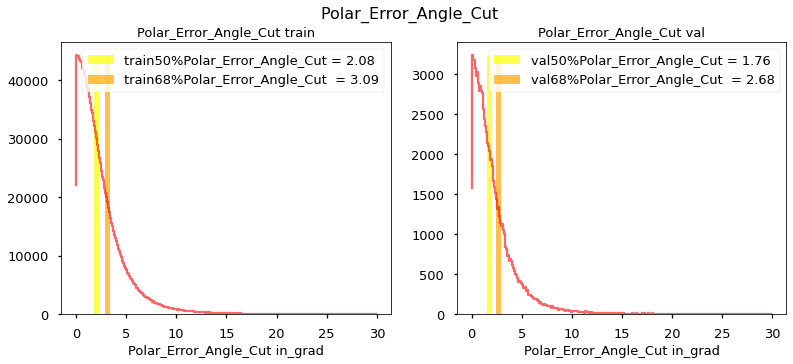

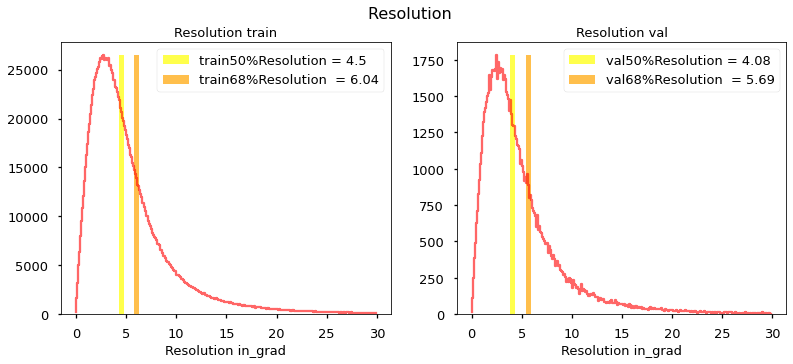

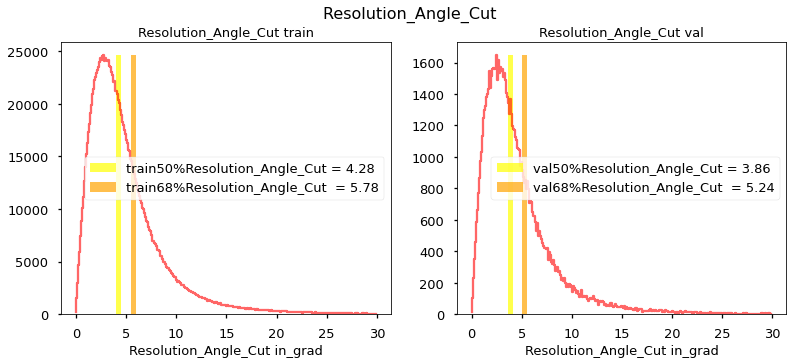

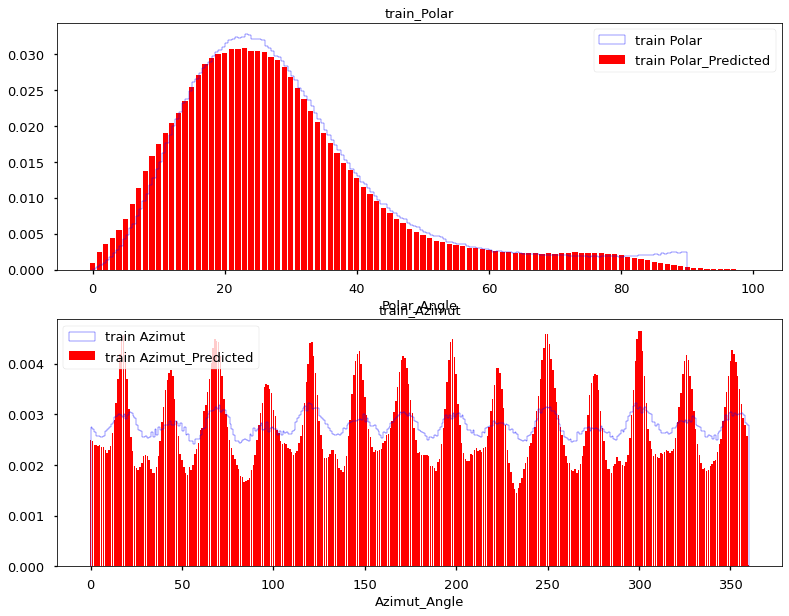

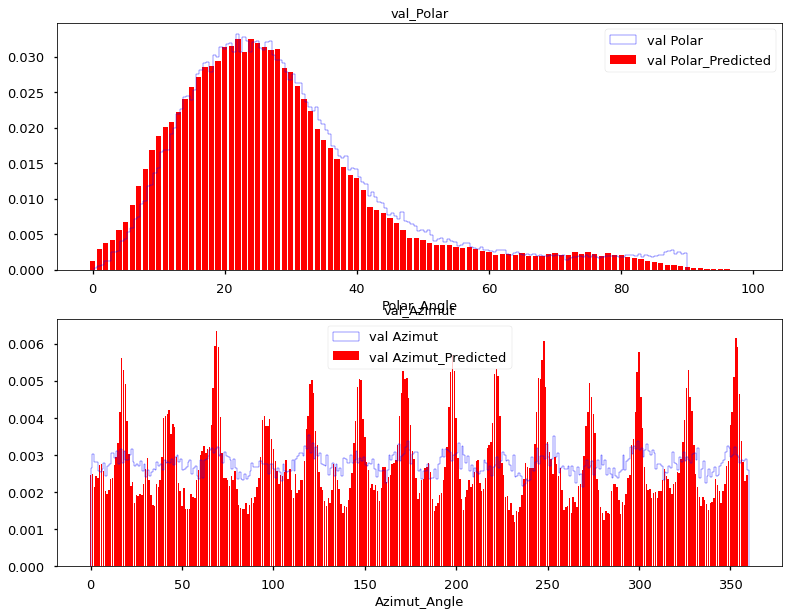

In [34]:
model = net.to(device)
learn_rate =5e-2
opt = torch.optim.Adam(model.parameters(),lr=learn_rate)
sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[10,20,30,40,45], gamma=0.8) 
loss_lists, polar_hists, azimut_hists ,res_hists ,polar_error =fitting(model,sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_Usual_1D",
                                                                       epochs_num=15, batch_size =64)
                                                              